In [1]:
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob  
import imageio

#  Data Sampling

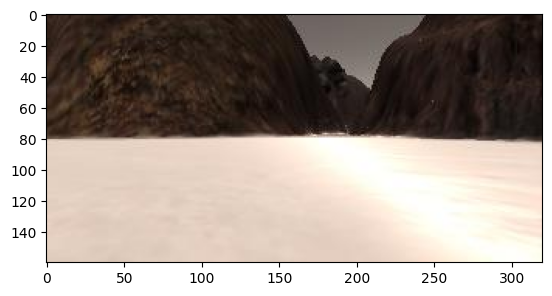

In [6]:
path = '../recorded_data/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Data sampling calibrated data

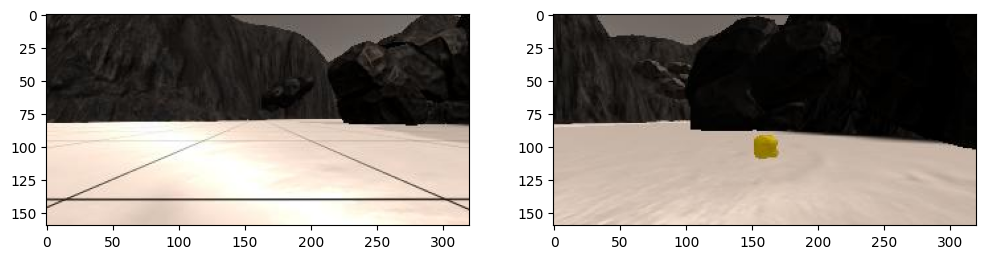

In [7]:
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

# Prespective transform
helps in maping image to real worldmap

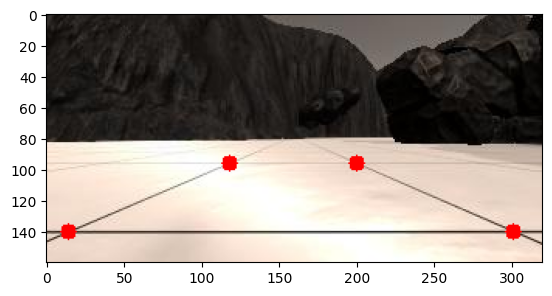

In [8]:
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

def mapPoints(img , points , color = (255,0,0)):
    img2 = img.copy()
    for point in points :
        cv2.circle(img2, tuple(point), 5, color, -1)
    return img2

illustrative_image = mapPoints(grid_img , source)
plt.imshow(illustrative_image) # show you how the source is choosen (red points is the source coordinates)

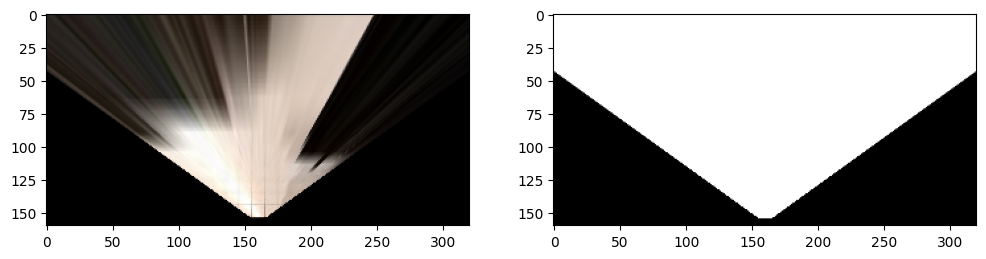

In [10]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    wraped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask = cv2.warpPerspective(np.ones((img.shape[0],img.shape[1])), M, (img.shape[1], img.shape[0]))# applying the same prespective transform to similar images filled with ones
    
    return wraped , mask


wraped , mask  = perspect_transform(grid_img,source,destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(wraped)
plt.subplot(122)
plt.imshow(mask,cmap='gray') # show the only area which have useful data

# Thresholding

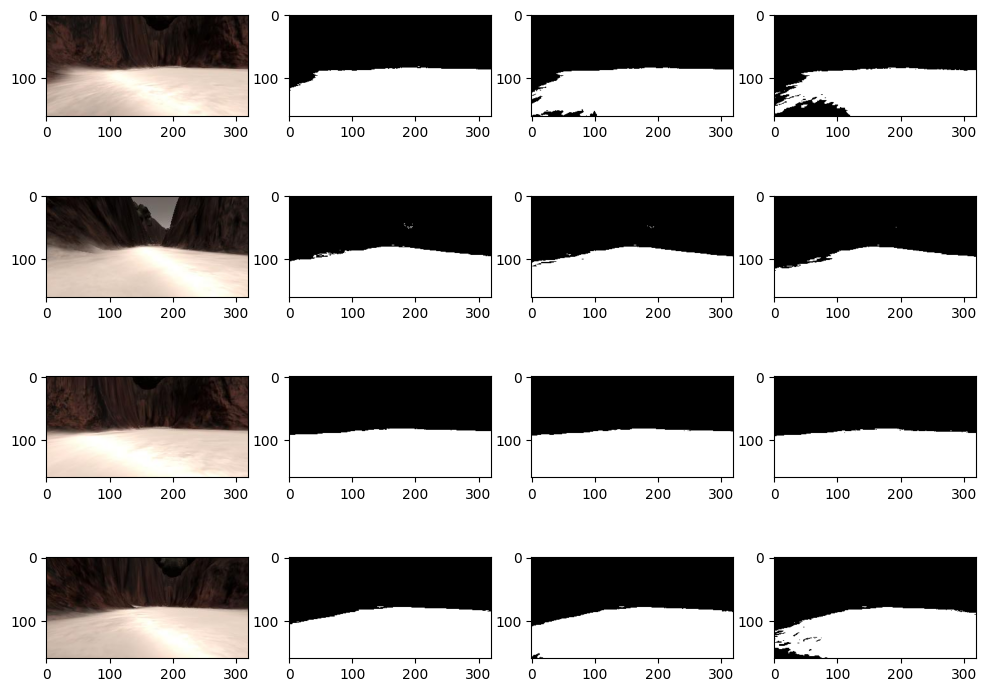

In [25]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# trying diffrent Thresholds (150,150,150) , (160, 160, 160) , (170, 170, 170) 
def testThreshSample(samples=4,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    np.random.seed(42)
    images = []
    thresh1 = []
    thresh2 = []
    thresh3 = []

    for i in range(0,4):
        idx = np.random.randint(0, len(img_list)-1)
        img = mpimg.imread(img_list[idx])
        images.append(img)
        thresh1.append(color_thresh(img,(150,150,150)))
        thresh2.append(color_thresh(img,(160, 160, 160)))
        thresh3.append(color_thresh(img,(170, 170, 170)))
    
    return images,thresh1,thresh2,thresh3


images,thresh1,thresh2,thresh3 = testThreshSample()
fig = plt.figure(figsize=(12,9))
     
for i in range(len(images)):
    plt.subplot(4,4,i*4+1)
    plt.imshow(images[i])
    plt.subplot(4,4,i*4+2)
    plt.imshow(thresh1[i],cmap='gray')
    plt.subplot(4,4,i*4+3)
    plt.imshow(thresh2[i],cmap='gray')
    plt.subplot(4,4,i*4+4)
    plt.imshow(thresh3[i],cmap='gray')
# picking on random doesn't guarantee that (150,150,150) is the best threshold so i will try on manually choosen data 

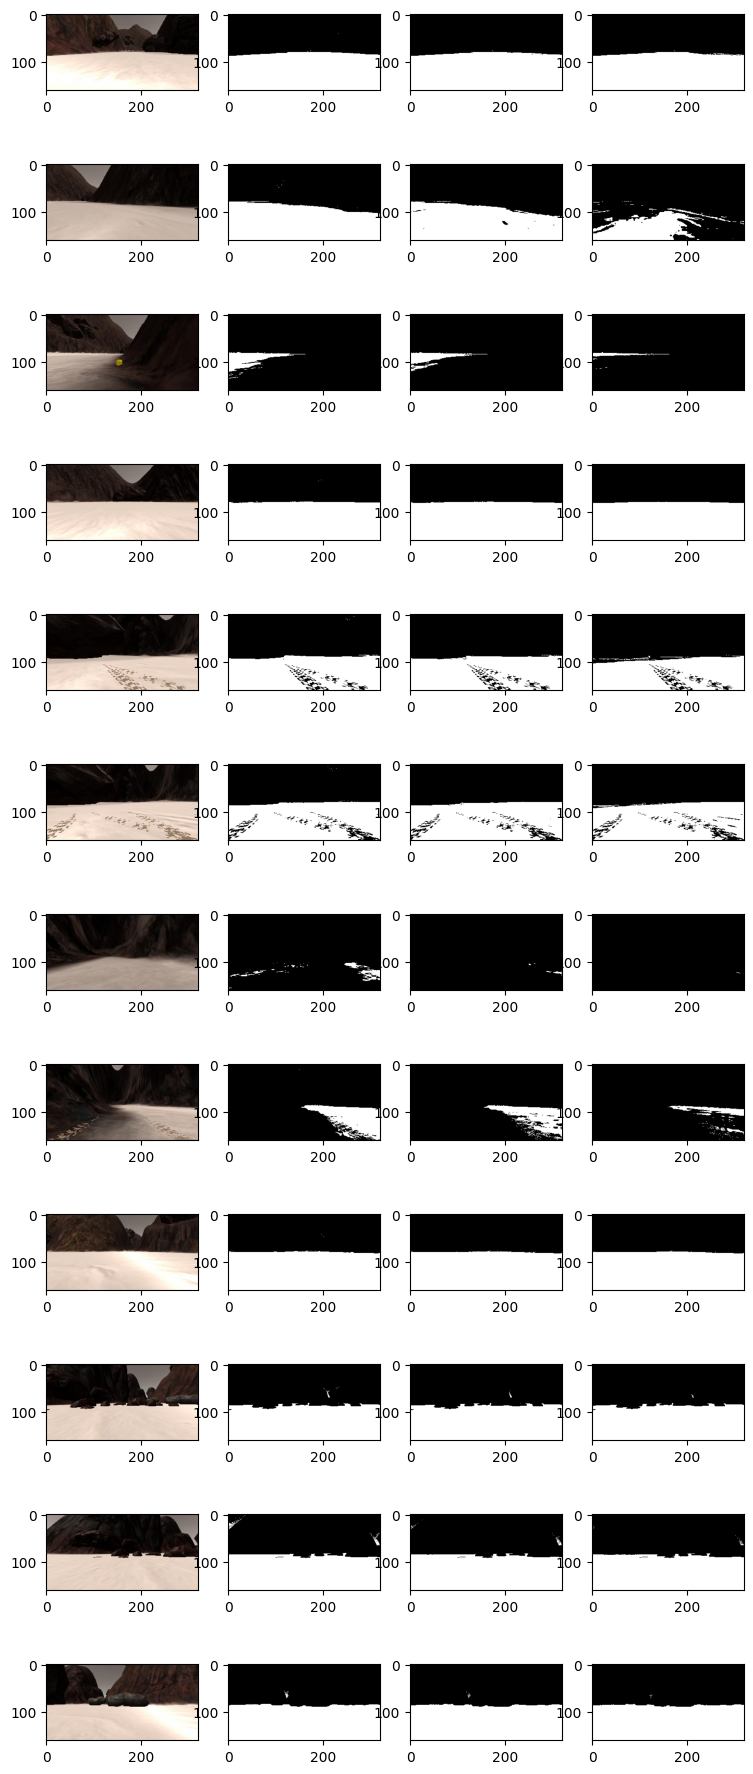

In [66]:
def testThresh(img,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    
    out = []
    for thresh in threshs :
        out.append(color_thresh(img,thresh))
    
    return out

def plot_threshs(path,threshs=[(150,150,150) , (160, 160, 160) , (170, 170, 170)]):
    img_list = glob.glob(path)
    fig = plt.figure(figsize=(9,25))
    for i in range(len(img_list)):
        image = mpimg.imread(img_list[i])
        plt.subplot(len(img_list)+1,4,i*4+1)
        plt.imshow(image)
        thresh1 , thresh2 , thresh3 = testThresh(image)
        plt.subplot(len(img_list)+1,4,i*4+2)
        plt.imshow(thresh1,cmap='gray')
        plt.subplot(len(img_list)+1,4,i*4+3)
        plt.imshow(thresh2,cmap='gray')
        plt.subplot(len(img_list)+1,4,i*4+4)
        plt.imshow(thresh3,cmap='gray')
    return img_list
path = '../recorded_data/thresholded_data/*'
img_list = plot_threshs(path)

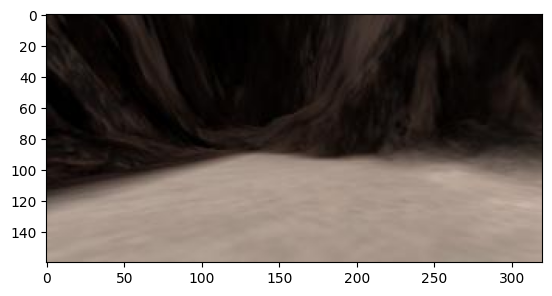

In [78]:
img_path = '../recorded_data/challenging/1.jpg' 
image = mpimg.imread(img_path)
plt.imshow(image)

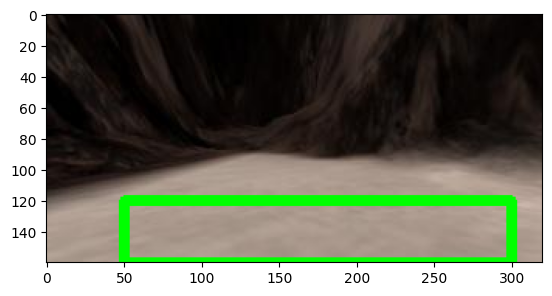

In [43]:
start_point = (50,120)
end_point = (300,160)
color = (0,255,0)
thickness = 5
copy = image.copy()
cv2.rectangle(copy, start_point, end_point, color, thickness)
plt.imshow(copy)

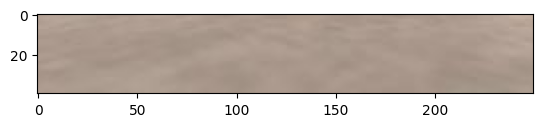

In [77]:
sample = image[start_point[1]:end_point[1],start_point[0]:end_point[0]]
plt.imshow(sample)

(array([[ 0.,  1., 12., ...,  0.,  0.,  0.],
        [ 0.,  0., 11., ...,  0.,  0.,  0.],
        [ 0.,  0.,  9., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  3.,  8., ...,  5.,  0.,  1.],
        [ 0.,  3.,  7., ...,  4.,  2.,  0.],
        [ 0.,  3.,  7., ...,  3.,  2.,  0.]]),
 array([128. , 131.7, 135.4, 139.1, 142.8, 146.5, 150.2, 153.9, 157.6,
        161.3, 165. ]),
 <a list of 250 BarContainer objects>)

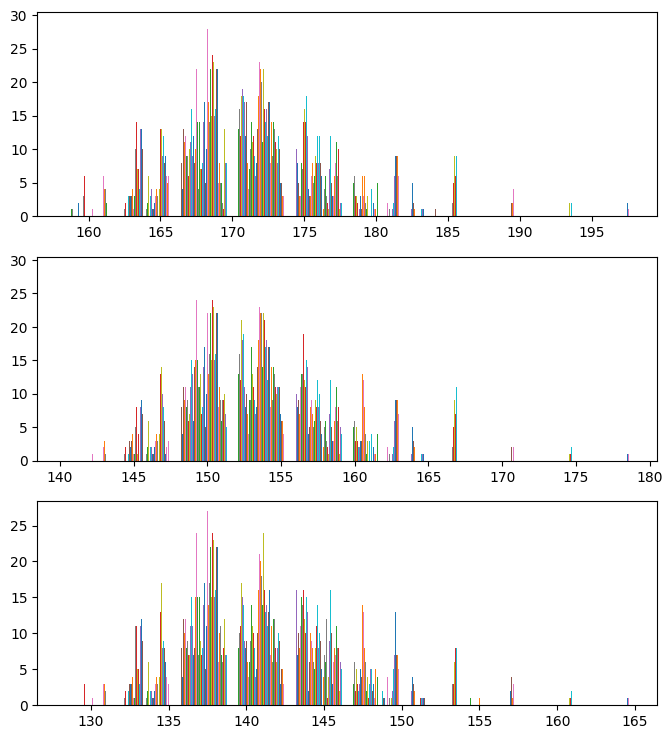

In [44]:
# we need to plot the histogram of each channel for this pixel to determine the right thresholding choice
fig = plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
plt.hist(sample[:,:,0])
plt.subplot(3,1,2)
plt.hist(sample[:,:,1])
plt.subplot(3,1,3)
plt.hist(sample[:,:,2])
# from histogram threshold on (B G R) , (155 , 140 , 127)

In [47]:
sample[:,:,0].min() , sample[:,:,1].min() , sample[:,:,2].min()

(158, 140, 128)

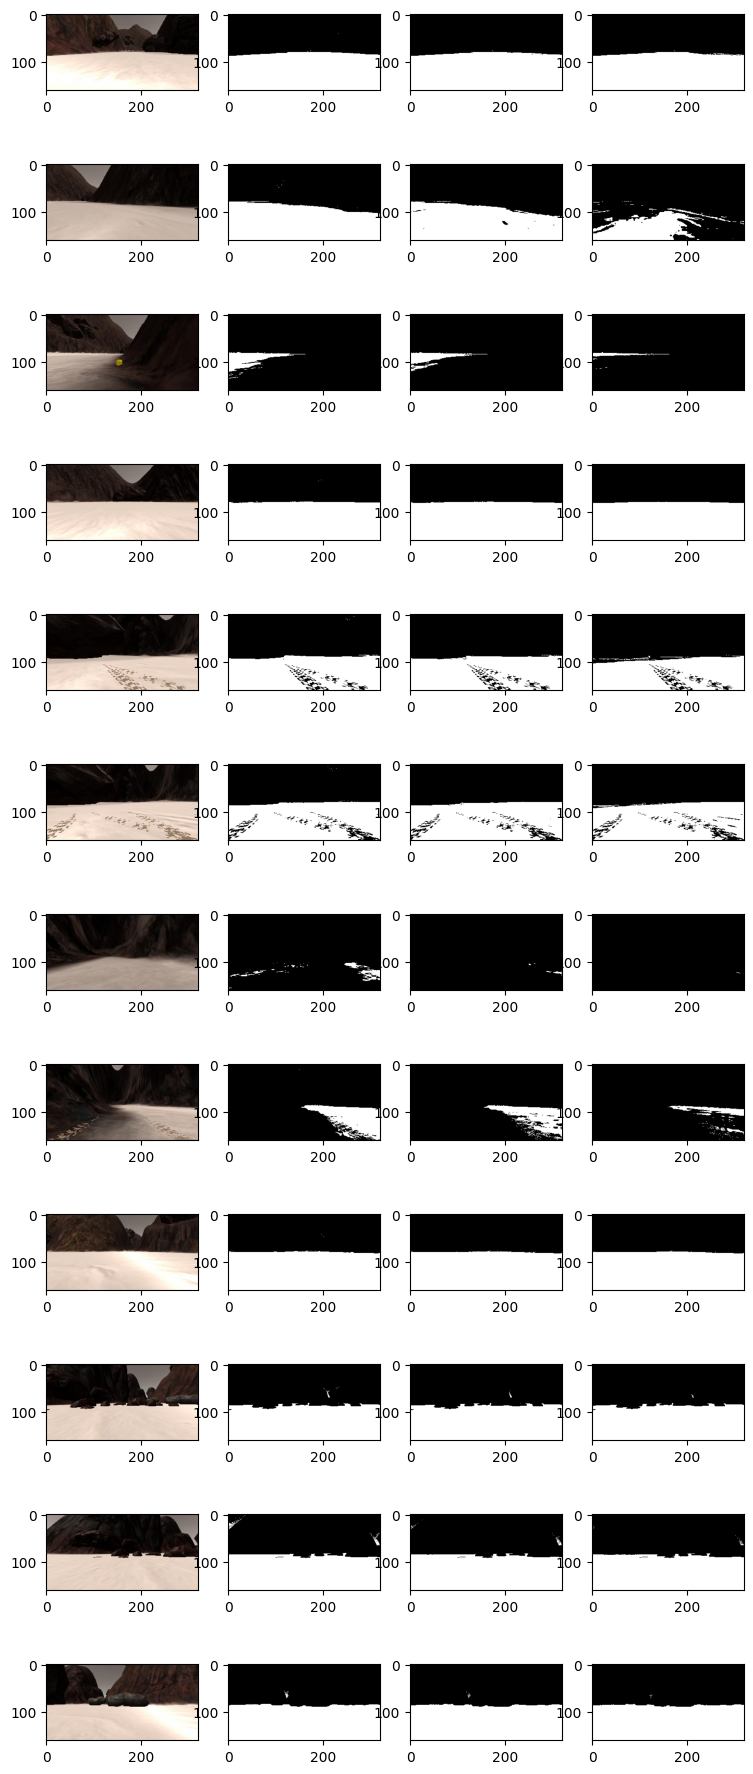

In [69]:
path = '../recorded_data/thresholded_data/*'
_ = plot_threshs(path,[(155 , 140 , 127),(130 , 130 , 130),(150 , 150 , 150)])

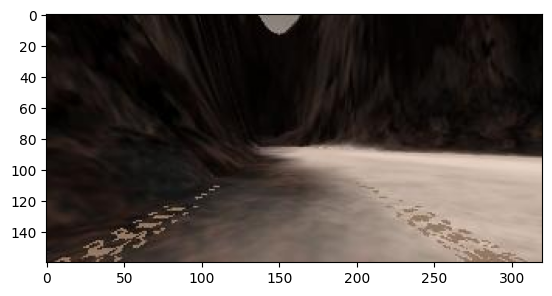

In [49]:
# path = '../recorded_data/challenging/2.jpg'
# img_list = glob.glob(path)
img_path = '../recorded_data/challenging/2.jpg'
image = mpimg.imread(img_path)
plt.imshow(image)

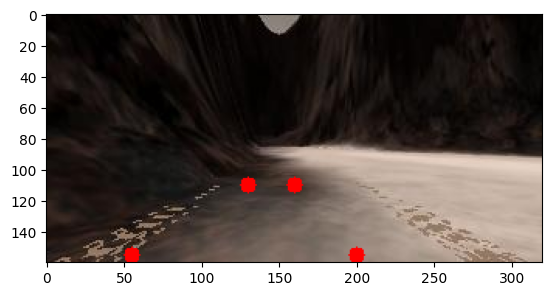

In [52]:
points = [(55,155),(130,110),(200,155),(160,110)]
maped = mapPoints(image,points)
plt.imshow(maped)

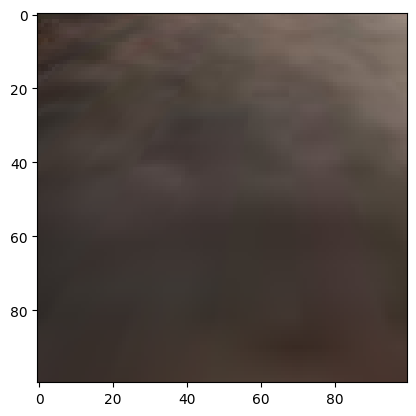

In [58]:
destination_thresh = [(0,0),(0,100),(100,0),(100,100)]
M = cv2.getPerspectiveTransform(np.float32(points),np.float32(destination_thresh))
transformed = cv2.warpPerspective(image, M, (100, 100))
plt.imshow(transformed)

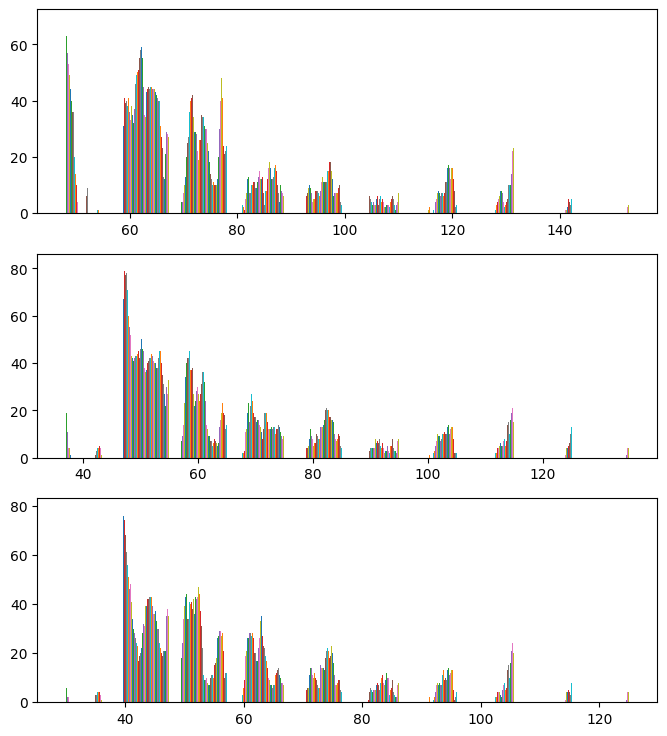

In [60]:
ig = plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
_ = plt.hist(transformed[:,:,0])
plt.subplot(3,1,2)
_ =plt.hist(transformed[:,:,1])
plt.subplot(3,1,3)
_ =plt.hist(transformed[:,:,2])

In [61]:
transformed[:,:,0].min() , transformed[:,:,1].min() , transformed[:,:,2].min() # very low values better to neglect this case

(47, 36, 29)

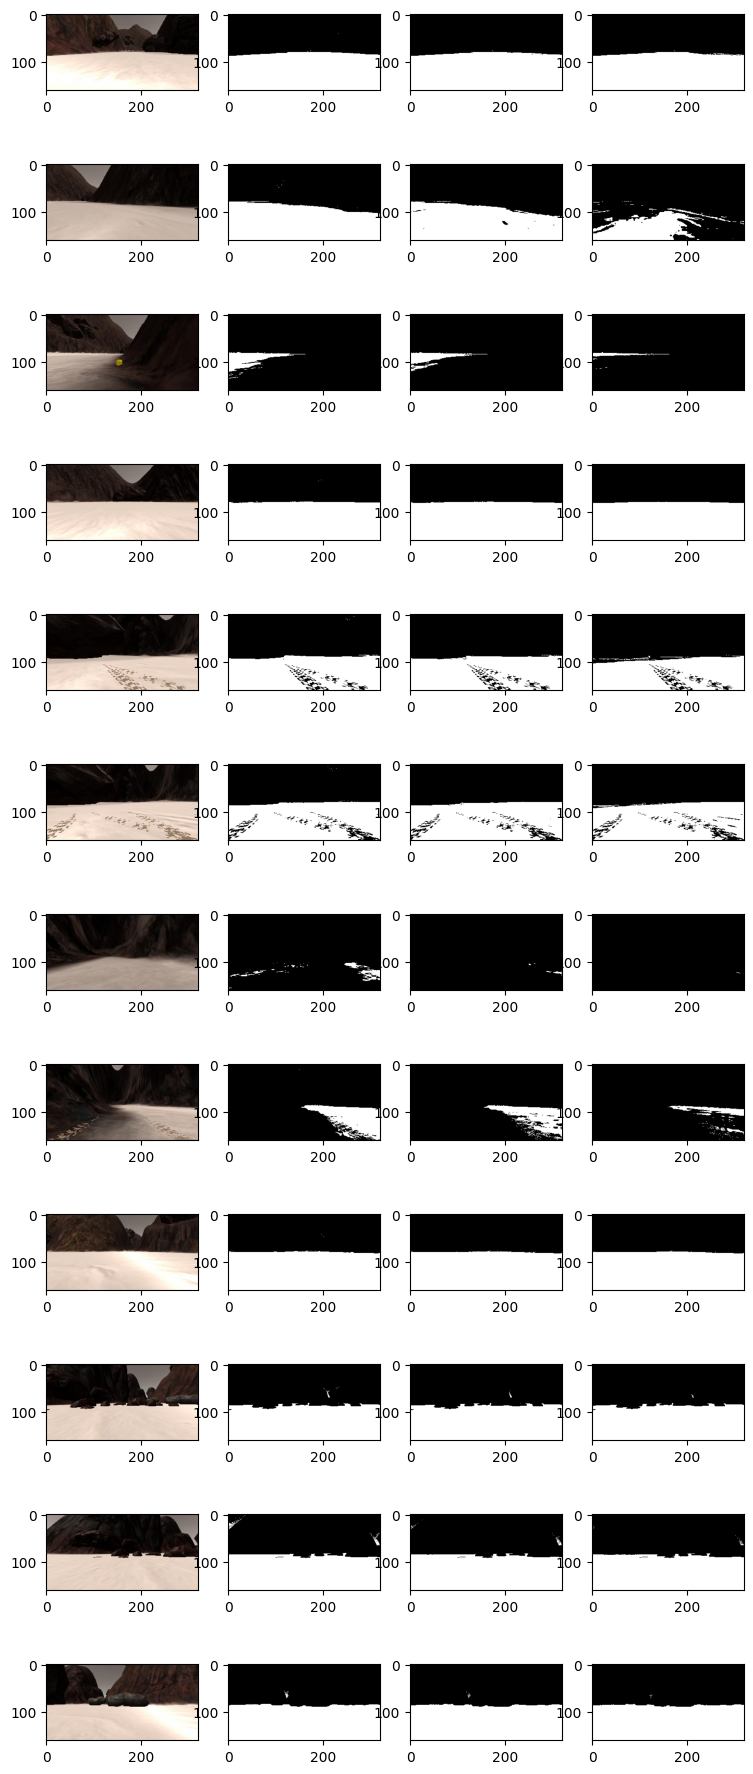

In [70]:
path = '../recorded_data/thresholded_data/*'
_ = plot_threshs(path,[(47, 36, 29) ,(120 , 100 , 90) , (155 , 140 , 127),])

## Try on with prespective transform

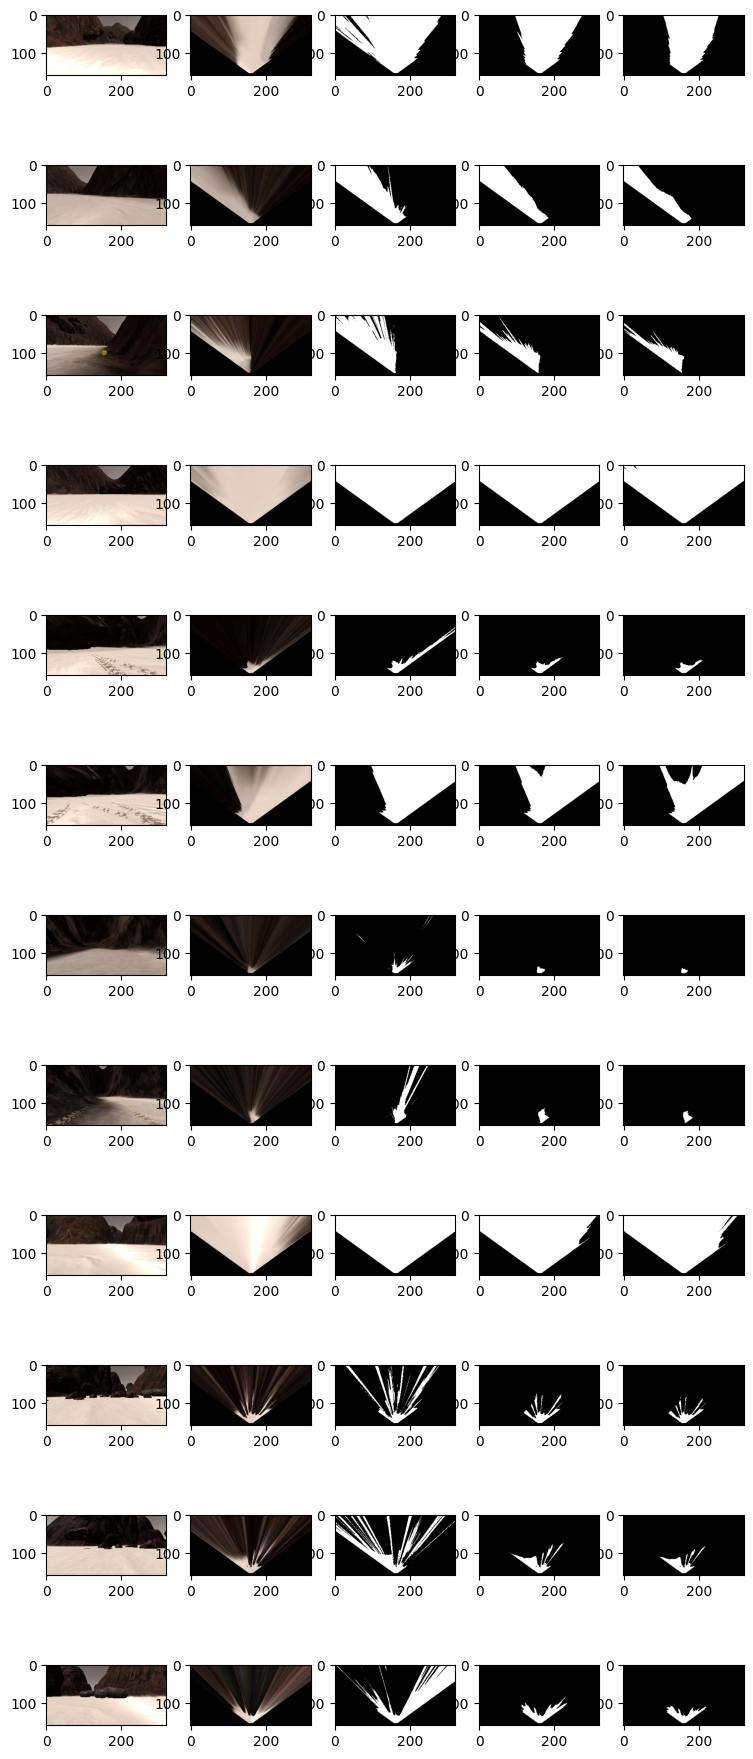

In [64]:
path = '../recorded_data/thresholded_data/*'
img_list = glob.glob(path)
fig = plt.figure(figsize=(9,25))
for i in range(len(img_list)):
    image = mpimg.imread(img_list[i])
    wraped , _  = perspect_transform(image,source,destination)
    plt.subplot(len(img_list)+1,5,i*5+1)
    plt.imshow(image)
    plt.subplot(len(img_list)+1,5,i*5+2)
    plt.imshow(wraped)
    thresh1 , thresh2 , thresh3 = testThresh(wraped,[(47, 36, 29) ,(120 , 100 , 90) , (155 , 140 , 127),])
    plt.subplot(len(img_list)+1,5,i*5+3)
    plt.imshow(thresh1,cmap='gray')
    plt.subplot(len(img_list)+1,5,i*5+4)
    plt.imshow(thresh2,cmap='gray')
    plt.subplot(len(img_list)+1,5,i*5+5)
    plt.imshow(thresh3,cmap='gray')


## Rocks

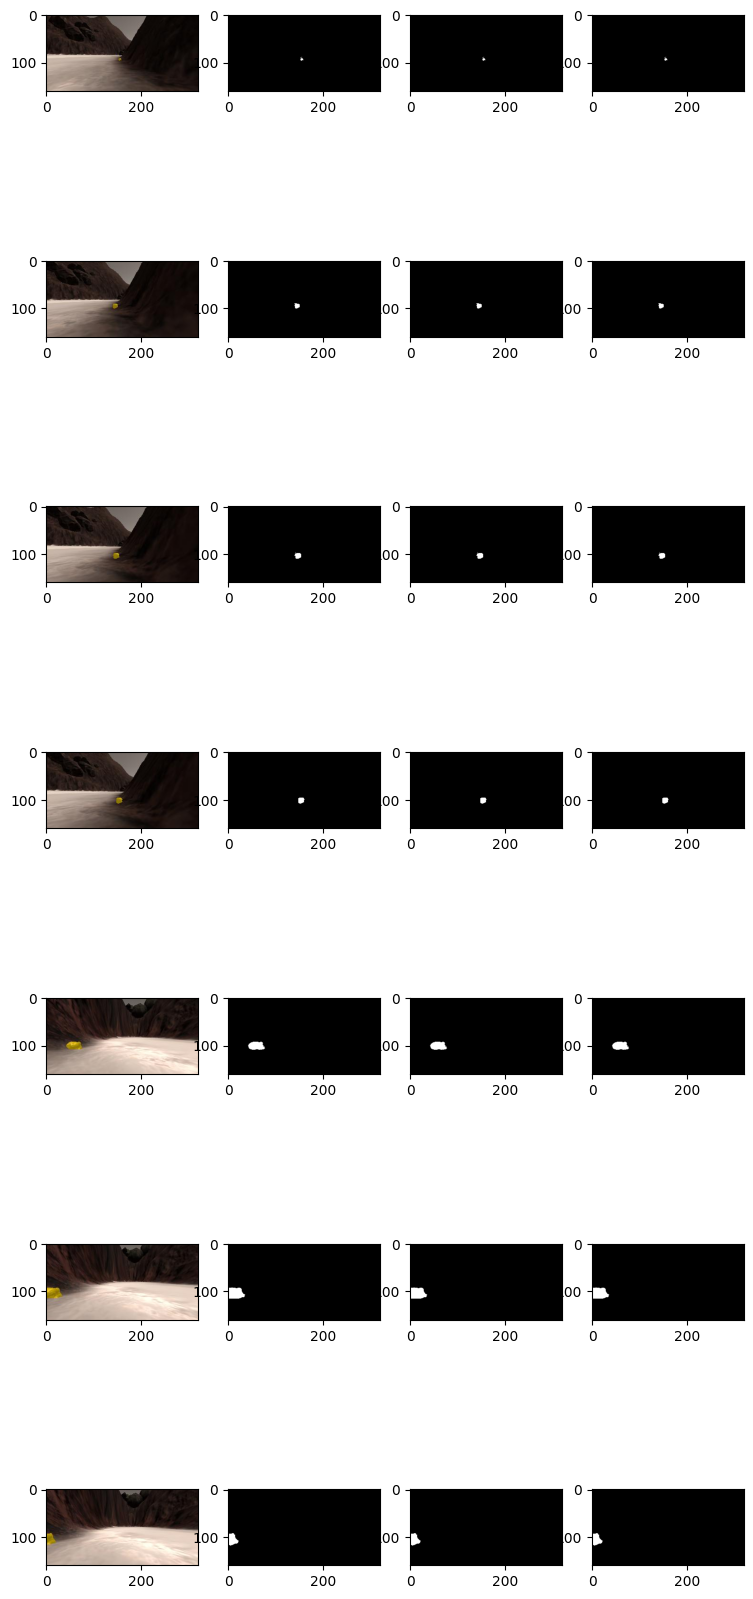

In [75]:
def color_thresh(img, rgb_thresh=(110, 110, 50)):
    # Create an array of zeros same xy size as img, but single channel
    lower_yellow = np.array([24-10,100,100])
    upper_yellow = np.array([24+10,255,255])

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only upper_yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Return the binary image
    return mask

path = '../recorded_data/rocks/*'
_ = plot_threshs(path) # rocks is easily detected in hsv